# Hyperparameter optimization with Bayesian optimization

Bayesian optimization (BO) is a tool to optimize black-box function, i.e., functions with unknown structure that are expensive to evaluate.
BO consists of the following steps that are repeated until one runs out of time or money:

1. Learn a model of the function
2. Using this model, find a promising point to evaluate next
3. Evaluate the point
4. Refine the model using the new observation

In this lab, we will first learn the BO concepts on a simple example to understand the inner workings and then transfer this to a real-world hyperparameter optimization task to see how you would implement it in practice. 
We will use Gaussian processes (GPs) as surrogate models.
Together with random forests (RFs), GPs are the most popular type of surrogate model.
Generally, a surrogate model for BO must provide an uncertainty estimate, i.e., for a given point, the model should be able to say how certain it is in its prediction.

In [11]:
from typing import Callable

import numpy as np
import scipy as sp
import seaborn as sns
from matplotlib import pyplot as plt

### We first define a synthetic benchmark function we will work on

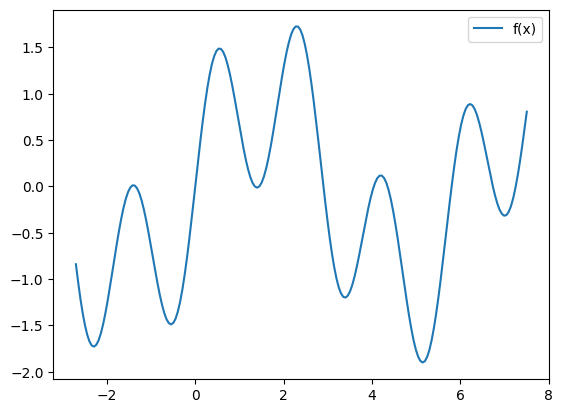

In [12]:
def fn(
        x: np.ndarray
) -> np.ndarray:
    y = np.sin(x) + np.sin((10.0 / 3.0) * x)
    return y


# define lower and upper bounds of the function: we will only search for the optimum within these bounds
lb, ub = -2.7, 7.5

plt.plot(np.linspace(lb, ub, 200), fn(np.linspace(lb, ub, 200)), label='f(x)')
plt.legend()
plt.show()

### Defining the training and test data
(This will be used further down)

In [13]:
x_train = np.random.RandomState(1).rand(5) * (ub - lb) + lb
x_train = x_train[:, np.newaxis]
y_train = fn(x_train)

x_test = np.linspace(lb, ub, 250)[:, np.newaxis]
y_test = fn(x_test)

# Implementing a Gaussian process

A GP can be seen as a probability distribution over _functions_.
One can draw functions from a GP and given some observations, one can update the probability distribution using Bayes' rule.
In particular, we assume that our function $f$ is distributed according to a GP:

$$
f(\mathbf{x}) \sim \mathcal{GP}(\mu(\mathbf{x}), k(\mathbf{x},\mathbf{x'})).
$$

$\mu$ is the _mean function_ and $k$ is the _kernel_ or _covariance function_. 
The mean function describes the average value of a point and the covariance function essentially captures how much two points are, on average, correlated.

In our example, we will use the RBF kernel:

$$
 k(\mathbf{x},\mathbf{x'}) = \exp\left(-\frac{||\mathbf{x}-\mathbf{x}'||^2}{2l^2}\right).
$$

This kernel-function has a larger value the closer $\mathbf{x}$ and $\mathbf{x'}$ are to each other, i.e., it assumes that the relation of two points is only determined by their distance. 
There are other kernels whose value depends on the location of the points but we will only work with kernels that have this "distance" assumption.
The parameter $l$ is a hyperparameter of the model.
We will see later how it affects the GP and we will see how it can be learned from the data.

## Defining an RBF kernel with a global lengthscale

**Your task:** Implement the RBF kernel as described above.

**Question:** What does a value of 1 mean, what does a value of 0 mean?

In [19]:
def kern(x: np.ndarray, x_prime: np.ndarray, ls: float) -> np.ndarray:
    """
    Returns the covariance matrix for x and x'. 
    
    Note: the output should always be a 2d matrix. If x or x' are 1d vectors (with d elements), we first reshape them to (1,d)-matrices.
    If x is of shape (n,d) and x' is of shape (m,d), the output will be a (n x m) matrix.
    """

    if x.ndim == 1:
        x = x[np.newaxis, :]
    if x_prime.ndim == 1:
        x_prime = x_prime[np.newaxis, :]
        
    sq_dist = np.sum(x**2, axis=1).reshape(-1, 1) + np.sum(x_prime**2, axis=1) - 2 * np.dot(x, x_prime.T)
    
    # Compute the RBF kernel
    return np.exp(-0.5 / ls**2 * sq_dist)

#### Safety check

The cell below should display the following image:

![RBF kernel plot](kernel_plot.png)

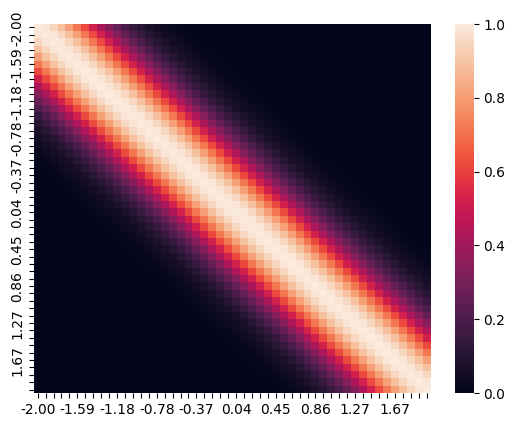

In [20]:
GRANULARITY = 50

x = np.linspace(-2, 2, GRANULARITY).reshape(-1, 1)
y = np.linspace(-2, 2, GRANULARITY).reshape(-1, 1)

xlabels = [''] * GRANULARITY
ylabels = [''] * GRANULARITY

for idx in np.arange(GRANULARITY)[::5]:
    xlabels[idx] = f"{x.squeeze()[idx]:.2f}"
    ylabels[idx] = f"{y.squeeze()[idx]:.2f}"

z = kern(x, y, 0.5)
assert z.ndim == 2, "kern must be a two dimensional matrix"
assert z.shape == (x.shape[0], x.shape[0]), f"kern should in this case yield a {x.shape[0]} by {x.shape[0]} matrix"
sns.heatmap(z, xticklabels=xlabels, yticklabels=ylabels)
plt.show()

## Defining a mean function (constant zero)

Surprisingly, the mean function is not really important. 
All we are interested in is the posterior of the GP, i.e., the distribution over functions after we have seen some data.
We will see that the prior mean (which is the mean function here) is unimportant for that.
Therefore, we can just implement the mean function as constant zero. This is especially true, as we tend to standardize our data so that is is zero mean.

**Your task:** Implement the mean function.



In [26]:
def mean(x: np.ndarray) -> np.ndarray:
    """
    Returns the mean. 
    
    If x is a 1d vector with d elements, reshape it to a (1 x d) matrix first.
    Should return a 2d zeros vector.
    
    """

    # ➡️ TODO : reshape to 2d ⬅️
    if x.ndim == 1:
        x = x[np.newaxis, :]
    
    # ➡️ TODO : implement the mean function ⬅️
    
    return np.zeros(x.shape[0])

#### Safety check

The output of the following cell should be __exactly__ `array([[0.]]) (1, 1)`

In [27]:
print(mean(np.zeros((1, 4))), mean(np.zeros(4)).shape)

[0.] (1,)


## Simple GP implementation

We will now use the mean and covariance functions to build a GP. 
In the `__call__` function, we will compute the posterior distribution for a vector of points `x`. The output will __not__ be an array, but a __multivariate Gaussian__ with the dimensionality of the length of `x`.

The posterior mean $\mu_n$ of a GP is calculated as follows:
$$
\mu_n(\mathbf{x}) = \Sigma_0(\mathbf{x},\mathbf{x}_{1:n})\Sigma_0(\mathbf{x}_{1:n},\mathbf{x}_{1:n})^{-1}(f(\mathbf{x}_{1:n})-\mu(\mathbf{x}_{1:n}))+\mu(\mathbf{x})
$$
where $\Sigma_{i,j}=k(\mathbf{x}_i,\mathbf{x}_j)$ is the kernel matrix or Gram matrix. $\mathbf{x}_{1:n}$ is the training data for which we have observed function values and $\mathbf{x}$ is the point for which we want to make predictions.

The posterior variance is calculated as 
$$
\sigma_n(\mathbf{x}) = k(\mathbf{x},\mathbf{x})-\Sigma_0(\mathbf{x},\mathbf{x}_{1:n})\Sigma_0(\mathbf{x}_{1:n},\mathbf{x}_{1:n})^{-1}\Sigma_0(\mathbf{x},\mathbf{x}_{1:n})^{\intercal}
$$

In the `fit`  function, we will set the training data and calculate a critical component: the inverse of the covariance matrix $\Sigma_0(\mathbf{x}_{1:n},\mathbf{x}_{1:n})^{-1}$.
Usually, this is done using Cholesky decomposition but we will use `np.linalg.inv` to calculate the inverse.

Pro tip: You might run into problems when computing the inverse due to numerical instabilities. If this happens, add a value of $10^{-6}$ to the diagonal elements of the matrix before computing the inverse.

**Your task:** Set the training data and compute the inverse of the covariance matrix $\Sigma_0(\mathbf{x}_{1:n},\mathbf{x}_{1:n})$.

In [ ]:
class GaussianProcess:
    def __init__(
            self,
            mean_function: Callable[[np.ndarray], np.ndarray],
            kern_function: Callable[[np.ndarray, np.ndarray], np.ndarray],
            ls: float
    ):
        # setting the mean function
        self.mean = mean_function
        # setting the kernel function, fix the lengthscale so we don't have to pass it all the time
        self.kern = lambda x, y: kern_function(x, y, ls)
        self.x_train = None
        self.y_train = None

    def initialize(self, x_train: np.ndarray, y_train: np.ndarray) -> 'GaussianProcess':
        # some checks
        assert x_train.ndim == 2 and y_train.ndim == 2, 'x_train and y_train should be 2D arrays'
        assert x_train.shape[0] == y_train.shape[0], 'first dimension of x_train and y_train has to be equal (n_points)'
        assert y_train.shape[1] == 1, 'y_train has to be of form (n_points, 1)'
        self.x_train = x_train
        self.y_train = y_train
        # Due to numerical instabilities, the covariance matrix might not be invertible.
        # We add a small constant value to the diagonal elements ('jitter') to enfore the
        # matrix to be positive semidefinite (which implies invertibility)
        # See, e.g., https://scicomp.stackexchange.com/questions/36342/advantage-of-diagonal-jitter-for-numerical-stability
        #
        #
        # The inputs x_train and y_train both have to be 2D here. x_train has shape (n_points, dim_of_points), y_train has
        # shape (n_points, 1)
        #
        # ➡️ TODO : compute the covariance and the inverse of the covariance matrix here. save them as class attributes so we don't need to
        #  recompute them all the time ⬅️
        #
        self.cov = ...
        self.cov_inv = ...
        return self

    def __call__(self, x: np.ndarray) -> sp.stats._multivariate.multivariate_normal_frozen:
        assert self.x_train is not None and self.y_train is not None, "Have to initialize the GP before calling"
        #
        # ➡️ TODO : compute the posterior distribution ⬅️
        #
        # First, compute the posterior mean and covariance (use self.cov_inv and the definitions above), 
        # then compute the posterior distribution which is a multivariate normal distribution
        # Hint: you might need to add a small diagonal value to the covariance matrix again
        # Use the code from above for that (don't add more than 1e-6)

        if x.ndim == 1:
            x = x[np.newaxis, :]
            
        return ...

    def posterior_mean(self, x: np.ndarray) -> np.ndarray:
        if x.ndim == 1:
            x = x[np.newaxis, :]
        dist = self(x)
        return dist.mean

    def posterior_covariance(self, x: np.ndarray) -> np.ndarray:
        if x.ndim == 1:
            x = x[np.newaxis, :]
        dist = self(x)
        return dist.cov

    def log_marginal_likelihood(
            self,
    ) -> float:
        #
        # ➡️ TODO : Implement this when you're instructed to in the notebook, you can skip this for now otherwise ⬅️
        # 
        
        return ...

: 

**Safety check:** Run the following cell to make sure that everything is working correctly.

In [ ]:
if isinstance(
        GaussianProcess(mean, kern, np.random.rand()).initialize(np.random.rand(5, 1), np.random.rand(5, 1))(
            np.random.rand(3, 1)
        ),
        sp.stats._multivariate.multivariate_normal_frozen
):
    print("✅ All good.")
else:
    print("🚨 __call__ does not return a multivariate distribution. Make sure to use 'sp.stats.multivariate_normal'")

: 

## Initializing and fitting the Gaussian process

In [ ]:
#
# ➡️ TODO : Create a new GP instance with a lengthscale of your choice. 
# Try different lengthscales to see how the affect the behavior of the GP.  ⬅️
#       

gp = ...
gp.initialize(x_train, y_train)

: 

### Plotting utility

In [ ]:
def plot_gp(gp: GaussianProcess, x_test: np.ndarray, y_test: np.ndarray, ax: plt.Axes = None) -> None:
    """
    Plot the GP posterior distribution of gp for a given set of test points (x_test and y_test).
    Accepts an optional parameter ax which plots it on an existing ax, otherwise a new figure
    is create.
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    posterior_distribution = gp(x_test)
    rvs = posterior_distribution.rvs(10)

    ci_lb = []
    ci_ub = []

    for _x in x_test:
        x_marginal = gp(_x)
        _mean = x_marginal.mean.squeeze()
        variance = x_marginal.cov.squeeze()

        _lb, _ub = sp.stats.norm.interval(0.95, loc=_mean, scale=np.sqrt(variance))
        ci_lb.append(_lb)
        ci_ub.append(_ub)

    ci_lb = np.array(ci_lb)
    ci_ub = np.array(ci_ub)

    for i, rv in enumerate(rvs):
        x_test_sq = x_test.squeeze()
        ax.plot(x_test.squeeze(), rv, alpha=0.25, color='blue', label='posterior sample' if i == 0 else None)
    ax.fill_between(x_test.squeeze(), ci_lb, ci_ub, color='gray', alpha=0.5, label='95% CI')
    ax.plot(x_test, y_test, color='red', label='f(x)')
    ax.scatter(x_train, y_train, marker='x', color='black', label='training data')
    ax.set_ylabel('f(x)')
    ax.legend()

: 

## Plot the above GP for the test data defined earlier

In [ ]:
plot_gp(gp, x_test, y_test)
plt.show()

: 

# Task: play around with lengthscales

* What happens if too low?
* What happens if too high?

## Systematic approach to fit lengthscales: MLE

We saw above that setting the lengthscale incorrectly can render the Gaussian process useless: if it is set too low or too high, the Gaussian process fails in modelling the function reasonably (if you didn't see that, try lengthscales of 0.1 and 10).
While you probably found a lengthscale value that led to reasonable performance, we want to set the lengthscale automatically because what a "good value" is depends on the function at hand.
All approaches to set the lengthscale (and often more hyperparameters) are in some form **maximizing the marginal likelihood of seeing the training data under the GP prior**:
$$
p(\mathbf{y}|X,l) = \int p(\mathbf{y}|\mathbf{f},X,l)p(\mathbf{f}|X,l)d\mathbf{f}
$$
We use the term _marginal_ likelihood because we are marginalizing over "functions" $\mathbf{f}$.
Note that $\mathbf{f}$ is a $n$-dimensional vector which represents one possible realization of the function $f$ at the locations $X \in \mathbb{R}^{n\times d}$.
The vector $\mathbf{f}|X$ follows a multivariate normal distribution, i.e., we marginalize over a normal distribution.

We use the most straightforward way of learning the lengthscale: maximum likelihood estimation (MLE):
$$
\hat{l} = \arg\max_l p(\mathbf{y}|X,l)
$$

We state the posterior (log) marginal likelihood here and refer to [Gaussian Processes for Machine Learning](https://gaussianprocess.org/gpml/chapters/RW.pdf) for a derivation:
$$
\log p(\mathbf{f}|X,l) = -\frac{1}{2}\mathbf{f}^\intercal K^{-1}\mathbf{f}-\frac{1}{2}\log |K| -\frac{n}{2}\log 2\pi
$$


**YOUR TASK**: Implement the `log_marginal_likelihood` in the `GP` class.

In [ ]:
# We define a function that we can pass to the minimize function from scikit learn

def negative_marginal_log_likelihood(ls: float) -> float:
    gp = GaussianProcess(mean, kern, ls)
    gp.initialize(x_train, y_train)
    return -gp.log_marginal_likelihood()

: 

### Maximize the marginal likelihood by minimizing the negative marginal log likelihood

**Safety check:** The following cell should print something close to `[0.6862108]`

In [ ]:
best_ls = sp.optimize.minimize(negative_marginal_log_likelihood, 1)['x']
print(best_ls)

: 

### Plot the GP with lengthscale fitted by MLE

In [ ]:
gp = GaussianProcess(mean, kern, best_ls)
gp.initialize(x_train, y_train)

posterior_distribution = gp(x_test)

plot_gp(gp, x_test, y_test)
plt.show()

: 

## Towards Bayesian Optimization: Acquisition functions

We now have all the ingredients of the Gaussian process and focus on the actual task: finding the optimizer of a function (i.e., the point with the best function value).
The general strategy is to first fit a Gaussian process on a small number of initial training points and then find the next point to evaluate.

We find this next point by maximizing a so-called _acquisition function_.
While it may seem strange to solve an optimization problem (maximizing the acquisition function) to maximize our black-box function, the acquisition function can be maximized using gradient-based approaches because it has a closed-form expression.

We will work with a popular acquisition function: __Expected improvement (EI)__.
EI describes by how much, in expectation w.r.t. to our GP posterior after $n$ observations, a given point improves over the current best function value $y^*_n$:
$$
EI_n(x) = \mathbb{E}_{f\sim GP(X,\mathbf{y})}\left[|f(x)-y^*_n| \right]
$$
EI naturally does an _exploration-exploitation tradeoff_: points that have already been evaluated get zero EI (in noiseless models as in this labs) but regions where all possible functions have a value worse than the current best point also get zero EI. 
The sweet spot are regions that are under-explored but are also promising.

Since our GP posterior follows a multivariate normal distribution, we can find a [closed form expression for the expected improvement](https://arxiv.org/pdf/1807.02811.pdf):
$$
EI_n(x) = \left [\Delta_n(x) \right ]^+ + \sigma_n(x)\varphi \left ( \frac{\Delta_n(x)}{\sigma_n(x)} \right ) - |\Delta_n(x)|\Phi \left ( \frac{\Delta_n(x)}{\sigma_n(x)} \right )
$$
where $\Delta_n(x) = \mu_n(x)-y^*_n$ is the expected difference between the point $x$ and the best function values after $n$ observations $y^*_n$, $\varphi(x)$ is the probability density function of the normal distribution, $\Phi$ is the cummulative density function of the normal distribution, and $[x]^+:=\max(0,x)$.
The quantities $\mu_n$ and $\sigma_n$ are the posterior mean and posterior standard deviation after $n$ observations.

__YOUR TASK:__ Implement the expected improvement acquisition function by adding missing lines in the cell below. You can use sp.stats for pds and cdfs.

In [ ]:
def expected_improvement(gp: GaussianProcess, x: np.ndarray) -> np.ndarray:
    if x.ndim == 1:
        x = x[np.newaxis, :]
    eis = []
    for _x in x:
        # ➡️ TODO : Implement the expected improvement acquisition function by adding missing lines  ⬅️
        ...
        eis.append(_ei.squeeze())
    return np.array(eis)

: 

__Safety check:__ (make sure you executed all cells in order up to here, i.e., you used the GP with MLE). 

You should get the following figure:

![EI plot](EI.png)

In [ ]:
plt.plot(expected_improvement(gp, np.linspace(lb, ub, 300).reshape(-1, 1)).squeeze(), label=rf'$EI_n(x)$')
plt.legend()
plt.show()

: 

## Bayesian optimization

Now, we have all the ingredients to do Bayesian optimization. We will 
* Sample some initial points and evaluate them
* Fit a GP model with MLE
* Find the next point to evaluate by maximizing the Expected improvement
* Evaluate the next point, add it to the data and start over from the second point 

We will now see how all components play together.

### Defining a function to maximize the likelihood

We wrap our MLE procedure in a single function that we can call conveniently later on. Given `mean`, `kern`, `x_train`, and `y_train`, this function returns a GP where the lengthscale is set by MLE. 

**Question (after running the BO loop):** Why is the model of the function so accurate in the middle part of the function but poor in the outer parts?

In [ ]:
def maximize_likelihood(
        mean: Callable[[np.ndarray], np.ndarray],
        kern: Callable[[np.ndarray], np.ndarray],
        x_train: np.ndarray, y_train: np.ndarray
) -> GaussianProcess:
    gp = GaussianProcess(mean, kern, 0.1)
    gp.initialize(x_train, y_train)

    def likelihood_function(x: np.ndarray) -> float:
        gp = GaussianProcess(mean, kern, x)
        gp.initialize(x_train, y_train)
        return -gp.log_marginal_likelihood()

    best_ls = sp.optimize.minimize(likelihood_function, 1)['x']

    gp = GaussianProcess(mean, kern, best_ls)
    gp.initialize(x_train, y_train)

    return gp

: 

In [ ]:
x_train = np.random.RandomState(2).rand(5) * (ub - lb) + lb
x_train = x_train[:, np.newaxis]
y_train = fn(x_train)

gp = maximize_likelihood(mean, kern, x_train, y_train)
ei = lambda x: expected_improvement(gp, x)

for i in range(10):
    print('###########################')
    print(f"####### iteration {i} #######")
    print('###########################')

    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(7, 7))
    # plot current GP
    plot_gp(gp, x_test, y_test, ax=axs[0])
    # stupidly optimize the acquisition function
    x_range = np.linspace(lb, ub, 1000)[:, np.newaxis]
    eis = ei(x_range)
    x_next = x_range[np.argmax(eis)]

    # plot acquisition function
    axs[1].plot(x_range, eis)
    axs[1].set_ylabel('EI(x)')
    axs[1].vlines(x_next, ymin=ei(x_next), ymax=0, color='green', linestyle='dashed', label='best x')
    axs[1].legend()
    plt.show(fig)
    # evaluate point where acquisition function maximum
    fx_next = fn(x_next)
    # add to training data
    x_train = np.vstack((x_train, x_next[np.newaxis, :]))
    y_train = np.vstack((y_train, fx_next[np.newaxis, :]))

    gp = maximize_likelihood(mean, kern, x_train, y_train)
    ei = lambda x: expected_improvement(gp, x)


: 

***
## PART 2
***
# Bayesian optimization in action

Now, we'll use Bayesian optimization to tune the hyperparameters of a neural network.
We will use the white wine dataset, which contains ~5.000 different wines with physical attributes and a taste score from users that goes from 1 to 10. Our goal is to train a predictor to guess the quality of the wine from its physical attributes. The data comes from the paper

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
Modeling wine preferences by data mining from physicochemical properties.
In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.

However, we only use a subset of the data set to speed up training. We will use [BoTorch](https://botorch.org/) Bayesian optimization library to optimize the hyperparameters.

![Wine plot](wine.jpg)

In [ ]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import model_selection

torch.manual_seed(0);

: 

In [ ]:
# Selecting the appropriate training device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device {device}")

: 

### Load the dataset

In [ ]:
df = pd.read_csv("winequality-white.csv", delimiter=";")
print(df.head())
print(df.describe())

# to speed up training we only use a subset of the data set. Feel free to play around. Especially if you have GPU support.
n_data_samples = 50

X = df.values[:n_data_samples, :-1]
y = df.values[:n_data_samples, -1]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train).to(dtype=torch.double, device=device)
X_test = torch.tensor(X_test).to(dtype=torch.double, device=device)
y_train = torch.tensor(y_train).to(dtype=torch.double, device=device)
y_test = torch.tensor(y_test).to(dtype=torch.double, device=device)

: 

We will use a relatively small ANN architecture with up to 4 hidden layers. We use dropout, with dropout probabilities that are subject to optimization. Furthermore, use ReLU activation functions.

In [ ]:
# Here we define the general architecture for the ANN. It takes 3 parameter: number of hidden layers, 
# number of neurons per hidden layer and dropout probability.

class ANN(torch.nn.Module):
    
    def __init__(
        self,
        n_hidden_layers: int,
        hidden_width: int,
        dropout_p: float
    ):
        super().__init__()
        self.model = torch.nn.Sequential(            
            torch.nn.Linear(torch.tensor(11), hidden_width),
            torch.nn.Dropout(dropout_p),
            torch.nn.ReLU(),
            *(
            torch.nn.Linear(hidden_width, hidden_width),                
            torch.nn.Dropout(dropout_p),
            torch.nn.ReLU(),
            ) * (n_hidden_layers),        
            torch.nn.Linear(hidden_width, 1)
        )

    def forward(self, x):
        return self.model(x)

: 

We will use the Adam optimizer with a learning rate that is subject to optimization. We will use the Mean Squared Error loss function.

To make the BO cleaner, we define the full training procedure in a function `black_box_function` that takes a vector of hyperparameters as input and returns the accuracy on the test set as output. We will use this function as a black box in the optimization. 

Note that the black_box_function takes inputs in the range [0,1] and then maps those to pre-set ranges inside the black_box_function.

We wrap the entire training and evaluation loop in a function that we can optimize.

In [ ]:
def black_box_function(x: torch.Tensor) -> float:
    """
    x[0]: number of hidden layers
    x[1]: number of neurons per layer
    x[2]: dropout p
    x[3]: learning rate
    x[4]: num training iterations
    """
    
    n_hidden = int(torch.floor(x[0] * 4)) # maps from [0,1] -> {0,..,4}
    n_neurons = int(torch.floor(x[1] * 996)) + 5 # maps from [0,1] -> {5, 500}
    dropout_p = 0.1 * x[2] # maps from [0,1] -> [0, 0.1]
    learning_rate = 0.1 * x[3] # maps from [0,1] -> [0, 0.1]
    num_gd_iters = int(torch.floor(x[4] * 1901) + 100) # maps from [0,1] -> {100, 2000}

    print(f'dropout: {dropout_p:.3E}', end='\t')
    print(f'lr: {learning_rate:.3E}', end='\t')
    print(f'depth: {n_hidden}', end='\t')
    print(f'width: {n_neurons}', end='\t')
    print(f'gd_iter: {num_gd_iters}')

    model = ANN(int(n_hidden), int(n_neurons), dropout_p).to(dtype=torch.double, device=device)

    #Defining the model hyperparameters
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate.item())

    #Training process begins
    model.train()
    for epoch in range(num_gd_iters):
        y_pred = model(X_train)
        loss = loss_fn(y_pred.reshape(-1), y_train.reshape(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
    model.eval()

    with torch.no_grad():
        y_train_pred = model(X_train)
        y_test_pred = model(X_test)
        train_loss = loss_fn(y_train_pred.reshape(-1), y_train.reshape(-1))
        test_loss = loss_fn(y_test_pred.reshape(-1), y_test.reshape(-1))
        print(f"Test loss = {test_loss:.3f}", f"[Training loss = {train_loss:.3f}]")
        

        # We maximize the negative test loss, i.e., minimize the loss
        return -test_loss.detach().cpu()

: 

### We test that the black box function works

In [ ]:
l = black_box_function(torch.tensor([1, 1,  0, .01, .1], dtype=torch.double, device=device))

: 

### Defining the GP model

We model the GP with GPyTorch. The Matern kernel is similar to the RBF kernel we used above. We have not talked about `ScaleKernel`s but they allow the model to adapt to the variance of the values of $f$. Finally, GPs can also model noisy functions. We haven't talked about noise above but the definitions of a noisy GP are almost identical to the ones of noiseless GPs.

In [ ]:
import gpytorch
from gpytorch.likelihoods import GaussianLikelihood

from botorch.models import SingleTaskGP


def get_gp(x_train: torch.Tensor, y_train: torch.Tensor) -> SingleTaskGP:
    # ➡️ TODO : Create a new SingleTaskGP and return the model  ⬅️
    # See https://botorch.org/api/_modules/botorch/models/gp_regression.html#SingleTaskGP for hints
    # You can try to improve your GP by choosing another kernel, another length scale prior, or 
    # another prior for the likelihood. The default should be fine though.

    model = ...
    return model

: 

### Cheap function to test if everything works

You can use the following test function to check if your BO loop runs as intended before running on the expensive HPO problem. On the Branin problem, you should reach a value of around -0.4 after approximately 200 function evaluations.

In [ ]:
from botorch.test_functions import Branin

cheap_function = Branin(negate=True)

: 

We will use a space-filling criterion ("scrambled Sobol sequence") to draw the initial points. 
This basically ensures that we sample evenly from the space, i.e., don't sample more from certain regions of the space than from others.
As above, we use Expected Improvement as the acquisition function. We will optimize the acquisition function using the L-BFGS algorithm. The Bayesian optimization loop will run for 24 iterations (and might take some time).



In [ ]:
import itertools
import random

import torch
from botorch.optim import optimize_acqf
from botorch.optim import optimize_acqf_mixed
from botorch.acquisition import ExpectedImprovement
from gpytorch import ExactMarginalLogLikelihood
from torch.quasirandom import SobolEngine
from botorch.utils.transforms import normalize, unnormalize
from botorch.fit import fit_gpytorch_mll

# Since some of our parameters are integer values, we need to ensure that we only evaluate the acquistion
# function at ``legal'' positions. We first define the feasible positions in the [0, 1] space and create
# a list of dictionaries that will be useful later
options_n_hidden = np.arange(4) / 4
options_n_neurons = (np.arange(5,501) - 5) / 501
options_gd_iters = (np.arange(100,2001) - 100) / 1901

fixed_features_list = []
# iterate over the cartesian product of feasible locations and add a dictionary entry for each
for _n_hid, _n_neur, _n_gd_it in itertools.product(options_n_hidden, options_n_neurons, options_gd_iters):
    fixed_features_list.append({
        0: _n_hid, # 0: index of 'n_hidden'
        1: _n_neur, # 1: index of 'n_neurons'
        4: _n_gd_it # 2: # 0: index of 'n_gd_iters'
    })
n_fixed_features = len(fixed_features_list) # this is a rather long list 

# ➡️ TODO : Set this to 'cheap_function' or 'black_box_function' ⬅️
function_to_optimize = ...
dim = 2 if isinstance(function_to_optimize, Branin) else 5

# draw d+1 initial points, replace values for discrete parameters with random values from our list
x_init = SobolEngine(dim, scramble=True).draw(dim+1)
for i_init in range(dim+1):
    fixed_features = fixed_features_list[np.random.choice(n_fixed_features)]
    for x_idx, x_val in fixed_features.items():
        x_init[i_init, x_idx] = x_val
    
fx_init = torch.tensor([function_to_optimize(x) for x in x_init]).reshape(-1, 1)

x = x_init
fx = fx_init

# Set to 500 for cheap function and to 24 for the HPO problem.
N_BO_STEPS  = 500 if isinstance(function_to_optimize, Branin) else 24
# Set to 1 for the HPO problem
PRINT_EVERY = 50 if isinstance(function_to_optimize, Branin) else 1


print('*** Starting Bayesian Optimization ***')
for gp_iter in range(N_BO_STEPS):
    if gp_iter % PRINT_EVERY == 0:
        print(f'** Iteration {gp_iter + 1}/{N_BO_STEPS} **')
    # We define the bounds for the optimization. We assume that all hyperparameters are between 0 and 1.
    bounds = torch.stack([torch.zeros(dim), torch.ones(dim)]) if not isinstance(function_to_optimize, Branin) else torch.stack([torch.tensor([-5, 0]), torch.tensor([10,15])])
    
    # ➡️ TODO : Normalize the x values to be between 0 and 1. You may use the botorch transforms  ⬅️
    # https://botorch.org/api/_modules/botorch/utils/transforms.html
    x_train = ...
    
    # ➡️ TODO : Normalize the y values to have mean zero and standard deviation one.  ⬅️
    fx_train = ...
    
    # ➡️ TODO : Create a new GP with the normalized x and y values (use your get_gp function from above) ⬅️
    gp = ...
    
    # Your GP model has an attribute `likelihood` which you can use to compute the marginal log likelihood.
    # This attribute gives the term p(y|f,X,l) in the marginal log likelihood which in our case
    # is a Gaussian (see https://docs.gpytorch.ai/en/stable/likelihoods.html#gaussianlikelihood )
    # ➡️ TODO : Define the marginal log likelihood of the model (see https://docs.gpytorch.ai/en/stable/marginal_log_likelihoods.html#exactmarginalloglikelihood ) ⬅️
    # ➡️ TODO : Train the model (see https://botorch.org/api/fit.html) ⬅️
    mll = ...

    # ➡️ TODO : fit the model by maximizing the marginal likelihood (see https://botorch.org/api/fit.html#botorch.fit.fit_gpytorch_mll)
    ...
    
    # ➡️ TODO : Define an acquisition function for your model. We'll use the Expected Improvement (see https://botorch.org/api/_modules/botorch/acquisition/analytic.html#ExpectedImprovement )  ⬅️
    ei = ...

    # we shuffle our list of values for discrete parameters and only keep the first 100 to keep a reasonably fast optimization
    random.shuffle(fixed_features_list)
    fixed_features_list_subsample = fixed_features_list[:100] 

    # ➡️ TODO : Optimize the acquisition function. You can use the optimize_acqf function (see https://botorch.org/api/optim.html#botorch.optim.optimize.optimize_acqf_mixed ) ⬅️
    # Set the number of candidates to 1, num restarts to 3, and raw_samples to 1024 , pass fixed_features_list_subsample for the fixed features
    
    x_next, acq_value = optimize_acqf_mixed(
        ...
    )
    
    # We unnormalize x_next to be in the original bounds
    x_next_unnorm = unnormalize(x_next, bounds).detach().cpu()

    # Lastly we evaluate your black-box function on the point suggested by the acquisition function
    fx_next = function_to_optimize(x_next_unnorm.squeeze())
    
    if gp_iter % PRINT_EVERY == 0:
        print(f'New function value: {fx_next.item():.4f}. Current best: {fx.max().item():.4f}')
        print('\n')
    x = torch.cat([x, x_next_unnorm])
    fx = torch.cat([fx, fx_next.reshape(-1, 1)])

x_bo = x
fx_bo = fx

: 

### Comparing BO to random search

We compare the performance of the models found by BO to randomly searching for ANN hyperparameters. Normally, we see that BO outperforms random search. Sometimes more, sometimes less. How does it perform in this case?

__Your task:__ Randomly initialize 30 CNNs and evaluate their performance. The performances should be in the 1D tensor `fx_rs`.

In [ ]:
# ➡️ TODO : Randomly initialize 30 ANNs and evaluate their performance.  ⬅️

x_rs = ...
fx_rs = ...

: 

## Plotting the evolution of performance

Assuming that we have sequential setting where we run one configuration at a time, we can plot the accuracy of best configuration seen so far against time. This way, the y value for the two methods state the performacen we would have stopped after x iterations.

In [ ]:
fx_bo_max = np.minimum.accumulate(-fx_bo)
fx_rs_max = np.minimum.accumulate(-fx_rs)

plt.plot(fx_bo_max, label='Bayesian Optimization')
plt.plot(fx_rs_max, label='Random Search')
plt.yscale('log')
plt.legend()
plt.show()

: 

Now if you want to, you can reuse this BO loop for your other machine learning projects, just replace the black box function for whatever you want to optimize. :) 